# Population Estimates: Compute CBG-level estimates using existing Cloud Factory annotations

We submitted ~700 tiles for CF to review prior to performing the population estimates. These tiles covered the same geographic areas for 2016, 2018 and 2020, and were sampled via random sampling stratified at the CBG-level. For this reason, although a CBG may not have been fully reviewed by CF, we assume that the 1 or 2 tiles reviewed for the CBG are representative of the small building density (number of small buildings per parcel) for the CBG. 

In [1]:
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [2]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds, assign_cbgs, visualize_tile_predvOSM, assign_cbgs_by_coverage
%run ADU_permit_matching-polygon-pipeline.ipynb import load_sources

In [4]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')
PERMIT_INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'inputs')
SJ_RES_PARCELS_FP = os.path.join(PERMIT_INPUT_FP, 'san_jose_parcels_res.geojson')

# Load sources for each year
TIF_FP, INFERENCES_DIR, IMG_FP = load_sources()
tile_bounds_dict_all, tiles_gdf = get_tile_dicts_all_years(oak_fp=OAK_FP, inferences_dir=INFERENCES_DIR)

# * Parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * CF annotations
CF_LABELS = pd.read_csv(os.path.join(OAK_FP, 'CloudFactory_phase1/cf_coords.csv'))

# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

100%|██████████| 3324/3324 [00:00<00:00, 7699.40it/s] 


## 1. Identify the universe of parcels annotated by CF

In [5]:
# Convert to GDF
CF_LABELS = gpd.GeoDataFrame(
    CF_LABELS, geometry=gpd.points_from_xy(CF_LABELS.longitude, CF_LABELS.latitude), crs='EPSG:4326')

In [6]:
# Collect tile names
CF_tiles = []
for cf_round in [1, 2]:
    round_path = os.path.join(
        OAK_FP, 'outputs/Temporal-Error-Analysis/Round{}/CF_Visualizations/2018'.format(cf_round))
    round_tiles = glob.glob(os.path.join(round_path, '*.png'))
    round_tiles = [tile.split(os.path.sep)[-1].replace('-small_2018.png', '') for tile in round_tiles]
    CF_tiles.extend(round_tiles)

In [7]:
# Collect tile geometries
CF_area_coverage = tiles_gdf['2020'].copy()
CF_area_coverage = CF_area_coverage.loc[CF_area_coverage['file'].isin(CF_tiles)]

In [8]:
# Collect associated parcels
CF_parcels = sj_parcels_cbgs.sjoin(CF_area_coverage, how='left', predicate='intersects')
CF_parcels = CF_parcels.loc[~CF_parcels['index_right'].isna()]
CF_parcels.drop('index_right', axis=1, inplace=True)

# Drop duplicate parcels (these are caused by parcels that belong to more than 1 tile)
CF_parcels.drop_duplicates('APN', inplace=True)
CF_parcels.drop('file', axis=1, inplace=True)

In [9]:
# CF annotated 17,973 unique parcels in total, for three years
len(CF_parcels)

17973

In [87]:
cbg_density

,GEOID,mean_density,std_density,year
0,060855001001,0.266667,0.576239,2016
1,060855001002,0.714286,0.487950,2016
2,060855001003,0.563107,0.544057,2016
3,060855001004,0.241379,0.435494,2016
4,060855002001,0.137931,0.350931,2016
...,...,...,...,...
244,060855120473,0.000000,NaN,2020
245,060855120522,0.091667,0.289765,2020
246,060855120523,0.000000,0.000000,2020
247,060855120531,0.052632,0.226294,2020


In [218]:
# Compute small building density per parcel per year for each CBG
cbg_density = pd.DataFrame()
parcel_density = pd.DataFrame()
for year in ['2016', '2018', '2020']:
    parcel_density_year = CF_parcels.copy()
    cf_labels_year = CF_LABELS.loc[CF_LABELS['year'] == int(year)]
    
    # Assign CF points to parcels
    parcel_density_year = parcel_density_year.sjoin(cf_labels_year, how='left')
    
    # Parcel density
    parcel_density_year = parcel_density_year.groupby(
        ['APN', 'GEOID'])['index_right'].count().reset_index()
    parcel_density_year['year'] = year
    
    # Aggregate at the CBG level (gives the mean density of the parcels reviewed by CF in a CBG)
    cbg_density_year = parcel_density_year.groupby('GEOID').agg(
        {'index_right': ['mean', 'std', 'count']}).reset_index()
    cbg_density_year.columns = ['-'.join(l) if l[1] != '' else l[0] for l in cbg_density_year.columns]
    
    cbg_density_year.rename(columns={'index_right-mean': 'mean_density', 
                                     'index_right-std': 'std_density', 
                                    'index_right-count': 'N_parcels_sampled'}, inplace=True)
    cbg_density_year['year'] = year
    
    # Append
    cbg_density = pd.concat([cbg_density, cbg_density_year])
    
    parcel_density_year.rename(columns={'index_right': 'parcel_density'}, inplace=True)
    parcel_density = pd.concat([parcel_density, parcel_density_year])

In [214]:
parcel_density.groupby(['year', 'neighborho'])['parcel_density'].mean().reset_index()

,year,neighborho,parcel_density
0,2016,high,0.130801
1,2016,low,0.177642
2,2018,high,0.090887
3,2018,low,0.148351
4,2020,high,0.173960
5,2020,low,0.242229


In [216]:
x = parcel_density.groupby(['year', 'neighborho', 'GEOID']).agg(
    {'parcel_density': ['mean', 'count']}).reset_index()
x.columns = ['-'.join(l) for l in x.columns]
x.groupby(
    ['year', 'neighborho'])['parcel_density'].mean().reset_index()

year neighborho         GEOID parcel_density      
                                             mean count
0    2016       high  060855001002       0.714286     7
1    2016       high  060855002001       0.137931    29
2    2016       high  060855002004       0.307692    39
3    2016       high  060855005001       0.198020   101
4    2016       high  060855005002       0.441026   195
..    ...        ...           ...            ...   ...
730  2020        low  060855120381       0.000000     6
731  2020        low  060855120421       0.000000     9
732  2020        low  060855120422       0.000000     3
733  2020        low  060855120522       0.091667   120
734  2020        low  060855120531       0.052632    38

[735 rows x 5 columns]

## 2. Aggregate at the CBG and neighborhood level

In [219]:
# Add neighborhood type
cbg_density = pd.merge(
    cbg_density, cbg_income_2016_SJ[['GEOID', 'neighborho', 'geometry']], how='left', 
    validate='many_to_one')

parcel_density = pd.merge(
    parcel_density, cbg_income_2016_SJ[['GEOID', 'neighborho']], how='left', validate='many_to_one'
)

In [220]:
#g = sns.FacetGrid(cbg_density, row="year", hue='neighborho', height=3.5, aspect=2.65)
#g.map(sns.kdeplot, 'mean_density')
#g.add_legend()
#plt.show()

In [221]:
# Add number of total parcels in each CBG
cbg_nparcels = sj_parcels_cbgs.groupby('GEOID')['APN'].count().reset_index()
cbg_density = pd.merge(cbg_density, cbg_nparcels, how='left', validate='many_to_one')
cbg_density.rename(columns={'APN': 'N_parcels'}, inplace=True)

In [222]:
cbg_density.head()

,GEOID,mean_density,std_density,N_parcels_sampled,year,neighborho,geometry,N_parcels
0,060855001001,0.266667,0.576239,105,2016,low,"POLYGON ((-121.90463 37.36078, -121.90449 37.3...",144
1,060855001002,0.714286,0.487950,7,2016,high,"POLYGON ((-121.89147 37.36290, -121.89036 37.3...",239
2,060855001003,0.563107,0.544057,206,2016,low,"POLYGON ((-121.88918 37.35723, -121.88916 37.3...",346
3,060855001004,0.241379,0.435494,29,2016,low,"POLYGON ((-121.90001 37.35498, -121.89936 37.3...",333
4,060855002001,0.137931,0.350931,29,2016,high,"POLYGON ((-121.91125 37.35418, -121.91083 37.3...",331


In [223]:
# Add percentage of sampled parcels
cbg_density['perc_sampled'] = cbg_density['N_parcels_sampled'] / cbg_density['N_parcels']

In [225]:
# Compute total sampled parcels per year/neighborhood
sampled_parcels = cbg_density.fillna(-1).groupby(['year', 'neighborho'])['N_parcels_sampled'].sum().reset_index()

In [226]:
sampled_parcels

,year,neighborho,N_parcels_sampled
0,2016,-1,164
1,2016,high,8318
2,2016,low,9491
3,2018,-1,164
4,2018,high,8318
5,2018,low,9491
6,2020,-1,164
7,2020,high,8318
8,2020,low,9491


In [228]:
# Compute weighted mean density and weighted total small buildings
#cbg_density['weighted_mean_density'] = cbg_density.apply(
#    lambda row: row['mean_density'] * row['N_parcels'] / sampled_parcels.loc[], 
#    axis=1)

# Before
#cbg_density['weighted_mean_density_sampled'] = cbg_density.apply(
#    lambda row: row['mean_density'] * row['N_parcels_sampled'] / cbg_density.groupby(['year'])['N_parcels'].sum()[row['year']], 
#    axis=1)

cbg_density['weighted_mean_density_sampled'] = cbg_density.apply(
    lambda row: 0 if pd.isnull(row['neighborho']) else row['mean_density'] * row['N_parcels_sampled'] / sampled_parcels.loc[
        (sampled_parcels['year'] == row['year']) & (
            sampled_parcels['neighborho'] == row['neighborho'])].iloc[0]['N_parcels_sampled'], 
    axis=1)

In [229]:
# Weighted mean and SD estimates
aggregates = cbg_density.groupby(['year', 'neighborho']).agg(
    {'weighted_mean_density_sampled': ['sum']}).reset_index()
aggregates.columns = ['-'.join(l) for l in aggregates.columns]

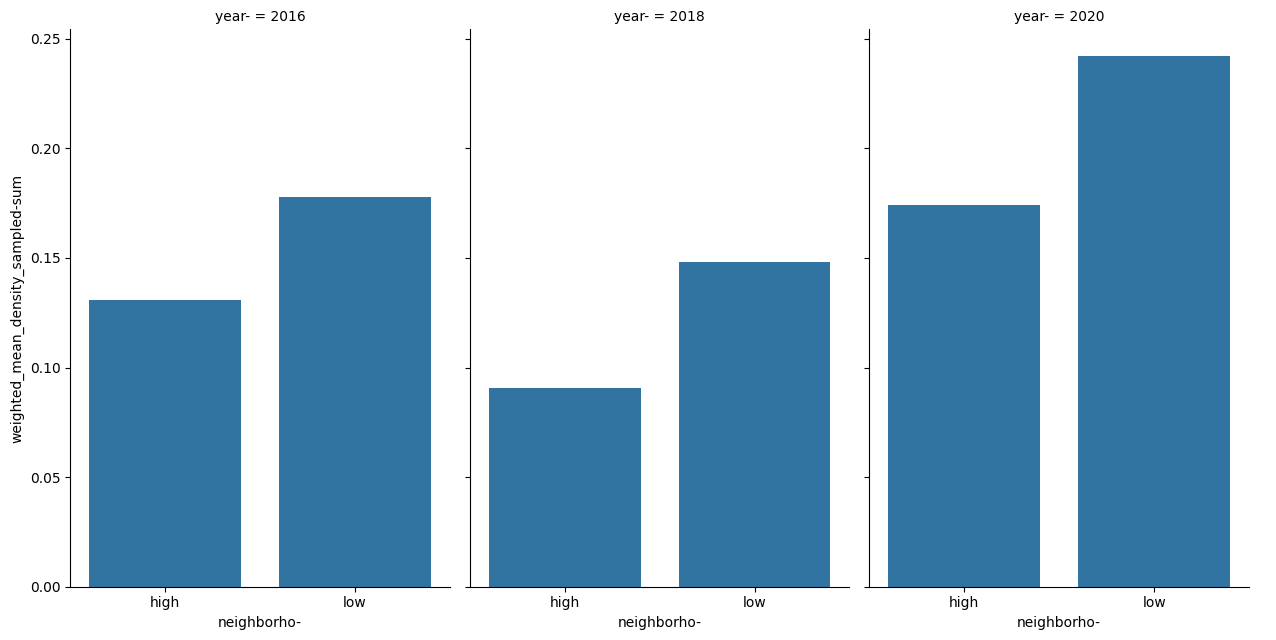

In [230]:
g = sns.FacetGrid(aggregates, col="year-",  height=6.5, aspect=.65)
#g.map(sns.barplot, 'neighborho-', 'weighted_total-sum')
g.map(sns.barplot, 'neighborho-', 'weighted_mean_density_sampled-sum')
g.add_legend()
plt.show()

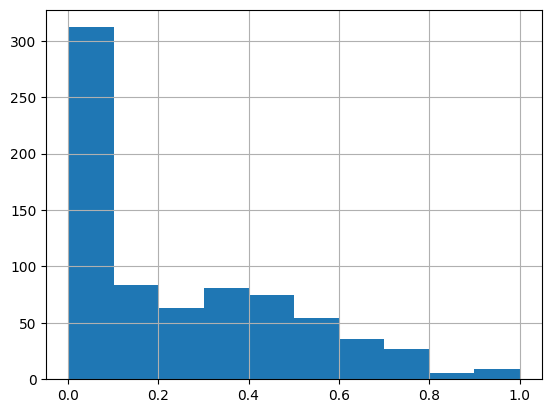

In [121]:
cbg_density['perc_sampled'].hist()
plt.show()

In [110]:
cbg_density['pop_weights'] = cbg_density.apply(
    lambda row: row['APN_x'] / cbg_density.groupby('year')['APN_x'].sum()[row['year']], axis=1)

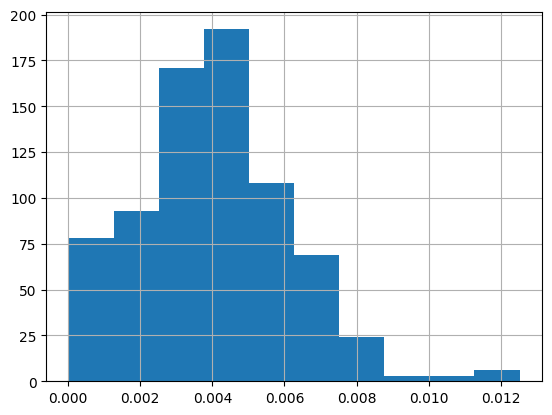

In [111]:
cbg_density['pop_weights'].hist()
plt.show()

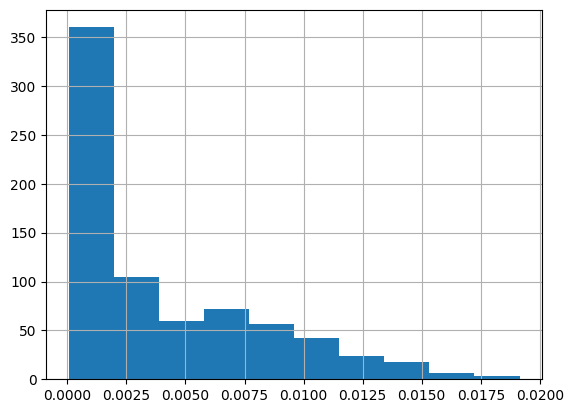

In [112]:
# sample weights
cbg_density['sample_weights'] = cbg_density.apply(
    lambda row: row['APN_y'] / cbg_density.groupby('year')['APN_y'].sum()[row['year']], axis=1)
cbg_density['sample_weights'].hist()
plt.show()

## 3. Power Analysis
Need to aggregate from the parcel level because we wish to compute the number of *parcels* that need to be reviewed.

In [128]:
aggregates_from_parcel = parcel_density.groupby(['year', 'neighborho']).agg(
    {'parcel_density': ['mean', 'std', 'count']}).reset_index()
aggregates_from_parcel.columns = ['-'.join(l) for l in aggregates_from_parcel.columns]

In [129]:
aggregates_from_parcel

,year-,neighborho-,parcel_density-mean,parcel_density-std,parcel_density-count
0,2016,high,0.130801,0.361301,8318
1,2016,low,0.177642,0.427024,9491
2,2018,high,0.090887,0.303736,8318
3,2018,low,0.148351,0.393188,9491
4,2020,high,0.173960,0.434654,8318
5,2020,low,0.242229,0.496576,9491


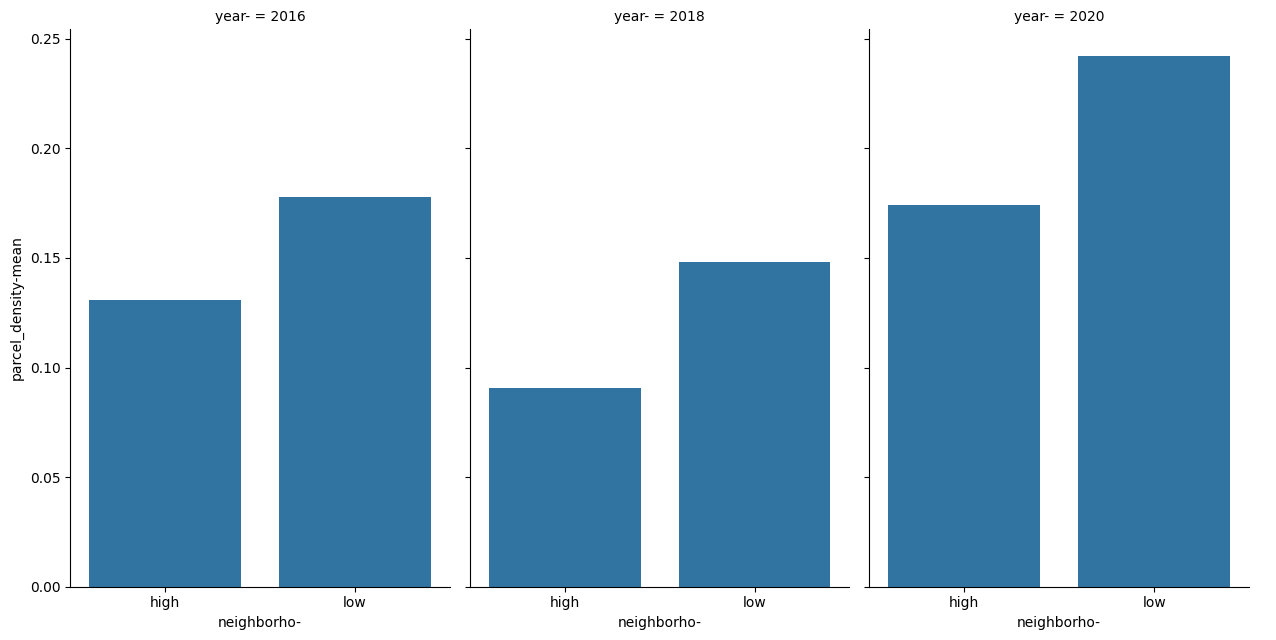

In [80]:
g = sns.FacetGrid(aggregates_from_parcel, col="year-",  height=6.5, aspect=.65)
g.map(sns.barplot, 'neighborho-', 'parcel_density-mean')
g.add_legend()
plt.show()

## S_j

In [184]:
cbg_density.loc[cbg_density['year'] == '2020'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 498 to 746
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   GEOID         249 non-null    object  
 1   mean_density  249 non-null    float64 
 2   std_density   241 non-null    float64 
 3   year          249 non-null    object  
 4   neighborho    245 non-null    object  
 5   geometry      249 non-null    geometry
dtypes: float64(2), geometry(1), object(3)
memory usage: 13.6+ KB


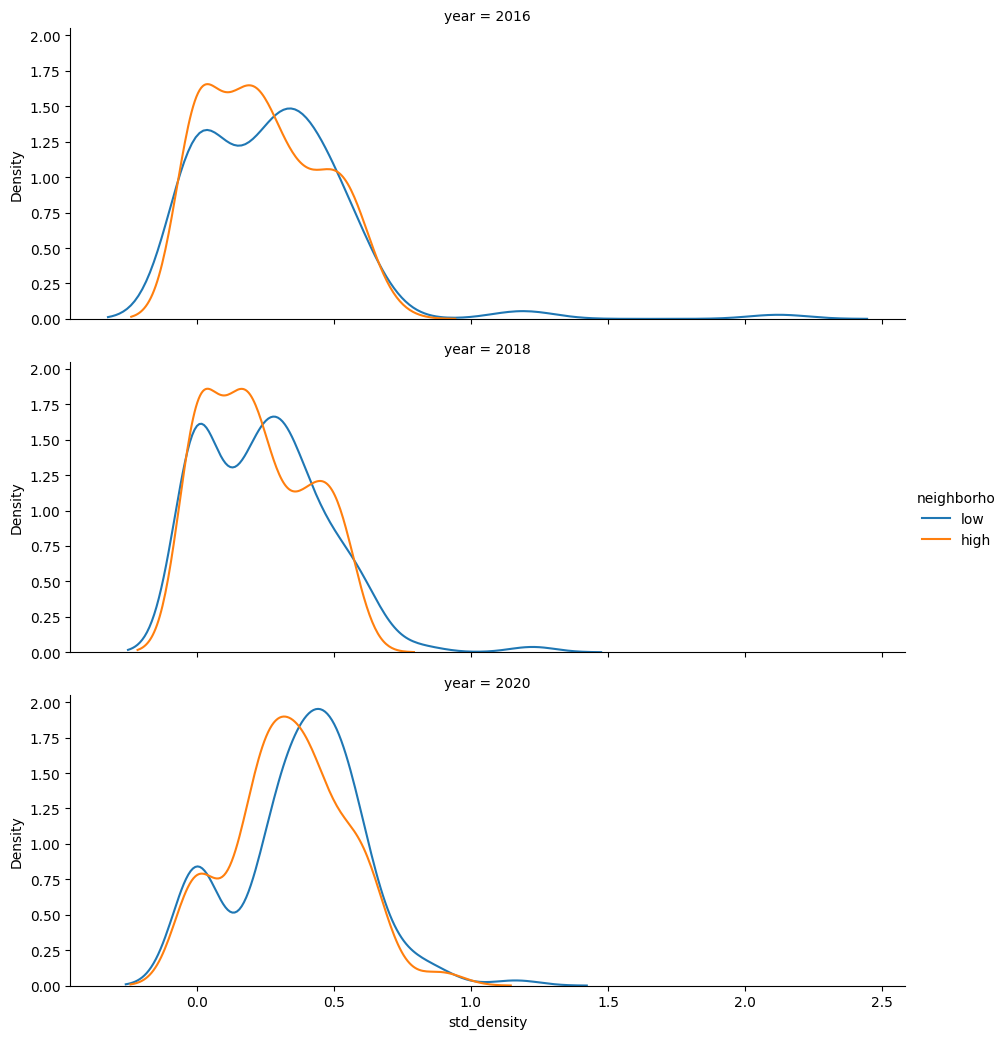

In [156]:
g = sns.FacetGrid(cbg_density, row="year", hue='neighborho', height=3.5, aspect=2.65)
g.map(sns.kdeplot, 'std_density')
g.add_legend()
plt.show()